# ADCP Lowpass Filter

- Take ADCP data (or other 2D current data)
- low pass filter (lanzcos) and rotate (arbitrary) degrees   
- missing data must be removed from start and end of timeseries


In [4]:
#load file and filter

import xarray as xa
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

In [5]:
%matplotlib inline

In [6]:
## up a few directories there is a filters folder

from inspect import getsourcefile
import os.path as path, sys
current_dir = path.dirname(path.abspath(getsourcefile(lambda:0)))
sys.path.insert(0, current_dir[:current_dir.rfind(path.sep)])
import filters.lanzcos as lanzcos  # Replace "my_module" here with the module name.
sys.path.pop(0)

'/Users/bell/Programs/Python/EcoFOCI_Jupyter_Notebooks'

**Load ADCP data with CF convention timewords**

In [7]:
filein='/Users/bell/scratch/adcp/19ckp2a/19ckp2a_wcp_vel.cf.nc'
xadata = xa.open_dataset(filein)

In [8]:
xadata

<xarray.Dataset>
Dimensions:    (depth: 17, lat: 1, lon: 1, time: 18758)
Coordinates:
  * time       (time) datetime64[ns] 2019-08-18T22:00:46 ... 2020-09-12T23:31:33
  * depth      (depth) float32 1.0 3.0 5.0 7.0 9.0 ... 25.0 27.0 29.0 31.0 33.0
  * lat        (lat) float32 71.22
  * lon        (lon) float32 164.3
Data variables:
    v_1206     (time, depth, lat, lon) float32 ...
    u_1205     (time, depth, lat, lon) float32 ...
    w_1204     (time, depth, lat, lon) float32 ...
    Werr_1201  (time, depth, lat, lon) float32 ...
Attributes:
    CREATION_DATE:        January 16, 2021 03:18 UTC
    COMPOSITE:            1
    INST_TYPE:            wcp
    DATA_CMNT:            14068.VEL
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    EDIT_CMNT01:          
    WATER_DEPTH:          45.0
    MOORING:              19CKP-2A
    WATER_MASS:           B
    EXPERIMENT:           
    PROJECT:              
    History:               \nJanuary 16, 2021 03:18 UTC EPIC two time-word ke...

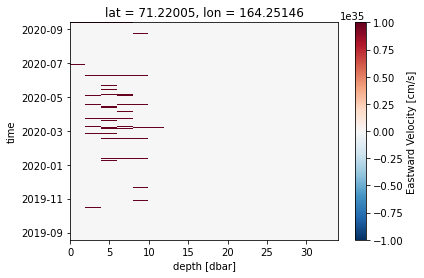

In [9]:
xadata.u_1205.plot()

In [10]:
#to do it pandas way
fdata=pd.DataFrame()
for depths in xadata.depth:
    udata = xadata.sel(depth=depths).u_1205[:,0,0].to_pandas()
    vdata = xadata.sel(depth=depths).v_1206[:,0,0].to_pandas()
    
    data = pd.concat([udata, vdata], axis=1)
    data.columns = ['udata','vdata']
    
    data['udata'][data.udata > 1.0e34]=np.nan
    data['vdata'][data.vdata > 1.0e34]=np.nan
    data = data.resample('1H').mean()
    
    ## missing data fill limited by number of hours to linearly interpolate
    data['tempu'] = data['udata'].interpolate(method='time',limit=6)
    data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index_u = np.isnan(data.tempu)
    missing_index_v = np.isnan(data.tempv)
    data['tempu'] = data['udata'].interpolate(method='time')
    data['tempv'] = data['vdata'].interpolate(method='time')
    
    #filter data with rudimentary matlab script
    data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
    data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
    data['ufdata'][missing_index_u] = np.nan
    data['vfdata'][missing_index_v] = np.nan
    
    #remove boundaries of large gaps

    """
    for index, row in data[np.isnan(data[var2filter_name+'_f35'])].iterrows():
            data[var2filter_name+'_f35'][index-datetime.timedelta(hours=17):index+datetime.timedelta(hours=17)] = np.nan
    """
    #remove start/end boundaries
    for index in range(0,17):
        data.loc[data.index[index]]['ufdata'] =np.nan
        data.loc[data.index[index]]['vfdata'] =np.nan

    for index in range(len(data)-17,len(data)):
        data.loc[data.index[index]]['ufdata'] =np.nan
        data.loc[data.index[index]]['vfdata'] =np.nan
        
    data.drop(columns=['tempu','tempv'],inplace=True)
    
    # rotate uv
    print("rotating vectors")
    # when rotating vectors - positive(+) rotation is equal to ccw of the axis (cw of vector)
    #                      - negative(-) rotation is equal to cw of the axis (ccw of the vector)
    angle_offset_rad = np.deg2rad(0)
    uprime = data["ufdata"] * np.cos(angle_offset_rad) + data["vfdata"] * np.sin(
        angle_offset_rad
    )
    vprime = -1.0 * data["udata"] * np.sin(angle_offset_rad) + data["vfdata"] * np.cos(
        angle_offset_rad
    )

    fdata["vfrdata_"+str(int(depths.values))] = vprime
    fdata["ufrdata_"+str(int(depths.values))] = uprime
    print(str(int(depths.values)))
    data.to_csv(filein.split('.cf.nc')[0]+str(int(depths.values))+'.csv')

rotating vectors
1
rotating vectors
3
rotating vectors
5
rotating vectors
7
rotating vectors
9
rotating vectors
11
rotating vectors
13
rotating vectors
15
rotating vectors
17
rotating vectors
19
rotating vectors
21
rotating vectors
23
rotating vectors
25
rotating vectors
27
rotating vectors
29
rotating vectors
31
rotating vectors
33


In [11]:
fdata.to_csv(filein.split('.cf.nc')[0]+'_35hrfiltered.csv')

<AxesSubplot:xlabel='time'>

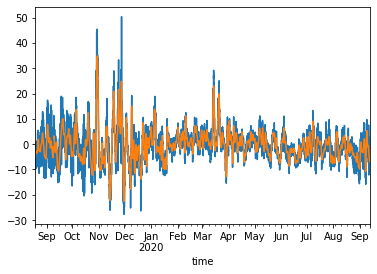

In [17]:
# for testing purposes, plot a single depth
data.vdata.plot()
fdata.vfrdata_33.plot()
